In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cartopy.crs as ccrs
import geopandas as gpd
import warnings

from tqdm.notebook import trange
from numba import njit
from cartopy.feature import ShapelyFeature
from shapely.geometry import Point
from shapely.vectorized import contains

warnings.filterwarnings("ignore")
projection = ccrs.Orthographic(central_longitude=90, central_latitude=30)
plt.rcParams['font.family'] = ['Times New Roman', 'SimSun']  # 无衬线字体栈
mpl.rcParams['font.size'] = 12

In [2]:
p_cn05_fp   = "../../Data/CN05/CN05_Pre_1961_2018_month_025.nc"
p_cn05_ds   = xr.open_dataset(p_cn05_fp)
p_cn05_lon  = p_cn05_ds['lon']
p_cn05_lat  = p_cn05_ds['lat']
p_cn05_data = p_cn05_ds['pre'] * 30.4
p_cn05_ds.close()

t_cn05_fp   = "../../Data/CN05/CN05_Tm_1961_2018_month_025.nc"
t_cn05_ds   = xr.open_dataset(t_cn05_fp)
t_cn05_lon  = t_cn05_ds['lon']
t_cn05_lat  = t_cn05_ds['lat']
t_cn05_data = t_cn05_ds['tm']
t_cn05_ds.close()

p_cru_fp    = "../../Data/CRU_TS/pre_1901_2024.nc"
p_cru_ds    = xr.open_dataset(p_cru_fp)
p_cru_lon   = p_cru_ds['lon']
p_cru_lat   = p_cru_ds['lat']
p_cru_data  = p_cru_ds['pre']
p_cru_ds.close()

t_cru_fp    = "../../Data/CRU_TS/tmp_1901_2024.nc"
t_cru_ds    = xr.open_dataset(t_cru_fp)
t_cru_lon   = t_cru_ds['lon']
t_cru_lat   = t_cru_ds['lat']
t_cru_data  = t_cru_ds['tmp']
t_cru_ds.close()

def get_mask(lon, lat, shape_gdf):
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    points = np.vstack((lon_grid.ravel(), lat_grid.ravel())).T
    mask = contains(shape_gdf.unary_union, points[:, 0], points[:, 1])
    mask = np.float32(mask)
    mask[mask == 0] = np.nan
    return mask.reshape(lon_grid.shape)

time_series_cn05 = pd.date_range(start='1961-01-01', end='2018-12-31', freq='MS')
time_series_cru  = pd.date_range(start='1901-01-01', end='2024-12-31', freq='MS')

study_st = pd.Timestamp('1961-01-01')
study_ed = pd.Timestamp('2024-12-31')

loc_cn05 = (time_series_cn05 >= study_st) & (time_series_cn05 <= study_ed)
loc_cru  = (time_series_cru  >= study_st) & (time_series_cru  <= study_ed)

p_cn05_study = p_cn05_data[loc_cn05, :, :].values
t_cn05_study = t_cn05_data[loc_cn05, :, :].values
p_cru_study  = p_cru_data[loc_cru, :, :].values
t_cru_study  = t_cru_data[loc_cru, :, :].values
time_series_cn05 = time_series_cn05[loc_cn05]
time_series_cru  = time_series_cru[loc_cru]

study_cat_fp = "../data/shape/study_catchments.shp"
study_cat_gdf = gpd.read_file(study_cat_fp)

In [71]:
basin_list = ['TNH', 'ZMD', 'CD', 'NX']
basin_zh_list = ['唐乃亥', '直门达', '昌都', '奴下']

for b in range(4):
    basin = basin_list[b]
    basin_zh = basin_zh_list[b]
    cat_gdf = study_cat_gdf[study_cat_gdf['Name'].isin([basin])]
    p_cn05_mask = get_mask(p_cn05_lon, p_cn05_lat, cat_gdf)
    t_cn05_mask = get_mask(t_cn05_lon, t_cn05_lat, cat_gdf)
    p_cru_mask  = get_mask(p_cru_lon, p_cru_lat, cat_gdf)
    t_cru_mask  = get_mask(t_cru_lon, t_cru_lat, cat_gdf)

    p_cn05_series = pd.Series(np.nanmean(p_cn05_study * p_cn05_mask, axis=(1, 2)), index=time_series_cn05)
    t_cn05_series = pd.Series(np.nanmean(t_cn05_study * t_cn05_mask, axis=(1, 2)), index=time_series_cn05)
    p_cru_series = pd.Series(np.nanmean(p_cru_study * p_cru_mask, axis=(1, 2)), index=time_series_cru)
    t_cru_series = pd.Series(np.nanmean(t_cru_study * t_cru_mask, axis=(1, 2)), index=time_series_cru)

    hc_df = pd.DataFrame(index=time_series_cru, columns=['pre_cru', 'tem_cru', 'pre_cn05', 'tem_cn05', 'runoff'])
    hc_df.index.name = 'Time'

    hc_df['pre_cru'] = p_cru_series
    hc_df['tem_cru'] = t_cru_series
    hc_df['pre_cn05'] = p_cn05_series
    hc_df['tem_cn05'] = t_cn05_series

    all_run = pd.read_excel(f"../../Data/中国水文站径流数据/Processed/{basin_zh}.xlsx").values
    year_list = all_run[:, 0]
    run_time_series = pd.date_range(start=f"{year_list[0].astype(int)}-01-01", end=f"{year_list[-1].astype(int)}-12-31", freq="MS")
    run_series = pd.Series(all_run[:, 1:].reshape(-1), index=run_time_series)
    run_series = run_series['1961-01-01':'2024-12-31']

    hc_df['runoff'] = run_series

    hc_df.to_csv(f"../data/hc/hc_{basin}.txt", index=True, sep='\t', float_format='%.2f')

In [72]:
basin1_list = ['TNH', 'ZMD', 'CD']
basin2_list = ['LZ',  'PZH', 'JZ']
basin_zh_list = ['兰州', '攀枝花', '旧州']

for b in range(3):
    basin1 = basin1_list[b]
    basin2 = basin2_list[b]
    basin_zh = basin_zh_list[b]
    cat_gdf = study_cat_gdf[study_cat_gdf['Name'].isin([basin1, basin2])]
    p_cn05_mask = get_mask(p_cn05_lon, p_cn05_lat, cat_gdf)
    t_cn05_mask = get_mask(t_cn05_lon, t_cn05_lat, cat_gdf)
    p_cru_mask  = get_mask(p_cru_lon, p_cru_lat, cat_gdf)
    t_cru_mask  = get_mask(t_cru_lon, t_cru_lat, cat_gdf)

    p_cn05_series = pd.Series(np.nanmean(p_cn05_study * p_cn05_mask, axis=(1, 2)), index=time_series_cn05)
    t_cn05_series = pd.Series(np.nanmean(t_cn05_study * t_cn05_mask, axis=(1, 2)), index=time_series_cn05)
    p_cru_series = pd.Series(np.nanmean(p_cru_study * p_cru_mask, axis=(1, 2)), index=time_series_cru)
    t_cru_series = pd.Series(np.nanmean(t_cru_study * t_cru_mask, axis=(1, 2)), index=time_series_cru)

    hc_df = pd.DataFrame(index=time_series_cru, columns=['pre_cru', 'tem_cru', 'pre_cn05', 'tem_cn05', 'runoff'])
    hc_df.index.name = 'Time'

    hc_df['pre_cru'] = p_cru_series
    hc_df['tem_cru'] = t_cru_series
    hc_df['pre_cn05'] = p_cn05_series
    hc_df['tem_cn05'] = t_cn05_series

    all_run = pd.read_excel(f"../../Data/中国水文站径流数据/Processed/{basin_zh}.xlsx").values
    year_list = all_run[:, 0]
    run_time_series = pd.date_range(start=f"{year_list[0].astype(int)}-01-01", end=f"{year_list[-1].astype(int)}-12-31", freq="MS")
    run_series = pd.Series(all_run[:, 1:].reshape(-1), index=run_time_series)
    run_series = run_series['1961-01-01':'2024-12-31']

    hc_df['runoff'] = run_series

    hc_df.to_csv(f"../data/hc/hc_{basin2}.txt", index=True, sep='\t', float_format='%.2f')

# 绘图

In [3]:
qtp_shp_fp = "../data/shape/QTP.shp"
qtp_gdf = gpd.read_file(qtp_shp_fp)

study_cat_fp = "../data/shape/study_catchments.shp"
study_cat_gdf = gpd.read_file(study_cat_fp)

hydro_station_fp = "../data/shape/hydro_stations.shp"
hydro_station_gdf = gpd.read_file(hydro_station_fp)

In [4]:
extent = [82, 104, 24.7, 38.5]
triangle_verts = [
    [0.0, -1.0],   # 底部中点
    [-0.5, 1.0],   # 左上角（宽度不变，高度拉长）
    [0.5, 1.0],    # 右上角（宽度不变，高度拉长）
    [0.0, -1.0]    # 闭合路径
]
elongated_triangle = mpath.Path(triangle_verts)

def plot_assist_element(ax, qtp_bound=True, study_cat=False, cat_fill=None, hydro_stations=False, hydro_stations_show=None):

    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    # gl.ylocator = mpl.ticker.FixedLocator([25, 30, 35, 40])
    # gl.top_labels = False
    # gl.right_labels = False
    # gl.left_labels = False

    if qtp_bound:
        feat = ShapelyFeature(qtp_gdf.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1.2, zorder=5)
        ax.add_feature(feat)

    if study_cat:
        feat = ShapelyFeature(study_cat_gdf.geometry, ccrs.PlateCarree(), edgecolor="#616161", facecolor='none', linewidth=1.0, zorder=6)
        ax.add_feature(feat)
        if cat_fill is not None:
            feat = ShapelyFeature(study_cat_gdf[study_cat_gdf['Name'].isin(cat_fill)].geometry, ccrs.PlateCarree(), facecolor='#FFBDBE', linewidth=0, zorder=5)
            ax.add_feature(feat)

    if hydro_stations:
        if hydro_stations_show is None:
            hydro_station_gdf.plot(ax=ax, color='red', markersize=200, marker=elongated_triangle, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=7)
        else:
            hydro_station_gdf[hydro_station_gdf['Name'].isin(hydro_stations_show)].plot(ax=ax, color='red', markersize=200, marker=elongated_triangle, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=7)
    ax.set_frame_on(False)

In [12]:
def get_valid_data(x, y):
    nan_mask_x = ~np.isnan(x)
    nan_mask_y = ~np.isnan(y)
    nan_mask = nan_mask_x & nan_mask_y
    return x[nan_mask], y[nan_mask]
def cal_polyfit(x, y):
    x_valid, y_valid = get_valid_data(x, y)
    p, q = np.polyfit(x_valid, y_valid, 1)
    return p, q
def add_text(ax, x, y, text, color='red', loc=1, ha='left', va='bottom'):
    if loc == 1:
        text_x = x[len(x)//3]
        text_y = y[len(y)//3]
    if loc == 2:
        text_x = x[0]
        text_y = y[0]
    if loc == 3:
        text_x = x[-1]
        text_y = y[-1]
    ax.text(text_x, text_y, text, fontsize=mpl.rcParams['font.size'], color=color, path_effects=[path_effects.withStroke(linewidth=3, foreground='white')], ha=ha, va=va)

def plot_trend_analysis(ax, data, ylabel=None, unit='mm'):
    ax.plot(data, color='black', marker='o', markersize=3)

    all_x = data.index.year
    all_y = data.values
    p, q = cal_polyfit(all_x, all_y)
    all_y_fit = p * all_x + q
    ax.plot(data.index, all_y_fit, color='red')
    add_text(ax, data.index, all_y_fit, f"{(p*10*86400*365/1e6):.0f} {unit}/10a", color='red')

    bef_data = data[data.index.year <= 1998]
    bef_x = bef_data.index.year
    bef_y = bef_data.values
    p, q = cal_polyfit(bef_x, bef_y)
    bef_y_fit = p * bef_x + q
    ax.plot(bef_data.index, bef_y_fit, color='blue')
    add_text(ax, bef_data.index, bef_y_fit, f"{(p*10*86400*365/1e6):.0f} {unit}/10a", color='blue', loc=2)

    aft_data = data[data.index.year > 1998]
    aft_x = aft_data.index.year
    aft_y = aft_data.values
    p, q = cal_polyfit(aft_x, aft_y)
    aft_y_fit = p * aft_x + q
    ax.plot(aft_data.index, aft_y_fit, color='blue')
    add_text(ax, aft_data.index, aft_y_fit, f"{(p*10*86400*365/1e6):.0f} {unit}/10a", color='blue', loc=3, ha='right')

    ax.set_xlabel('年份')
    ax.set_ylabel(ylabel)

## 单个流域绘图

In [6]:
basin_list = ['TNH', 'LZ', 'ZMD', 'PZH', 'CD', 'JZ', 'NX']
hydro_show_list = [['TNH'],
                   ['LZ'],
                   ['ZMD'],
                   ['PZH'],
                   ['CD'],
                   ['JZ'],
                   ['NX'],
                   ]
fill_list = [['TNH'],
             ['TNH', 'LZ'],
             ['ZMD', 'ZMD'],
             ['ZMD', 'PZH'],
             ['CD',  'CD'],
             ['CD',  'JZ'],
             ['NX',  'NX'],
             ]

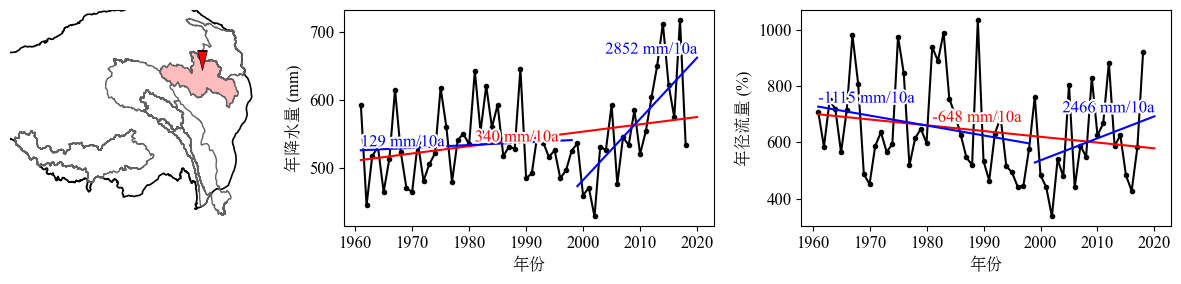

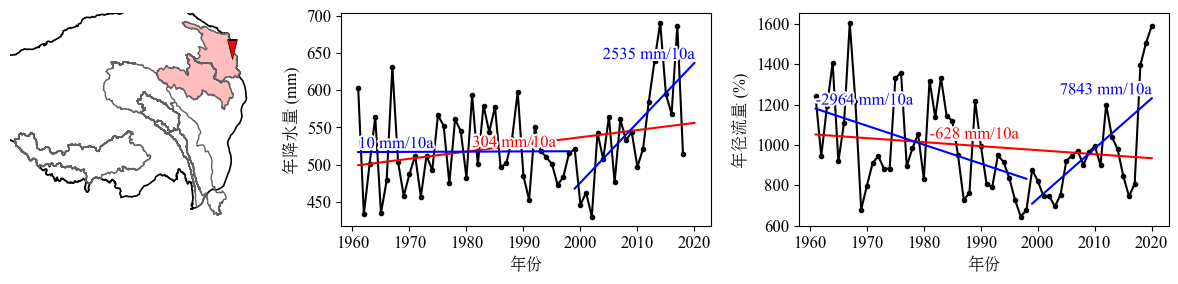

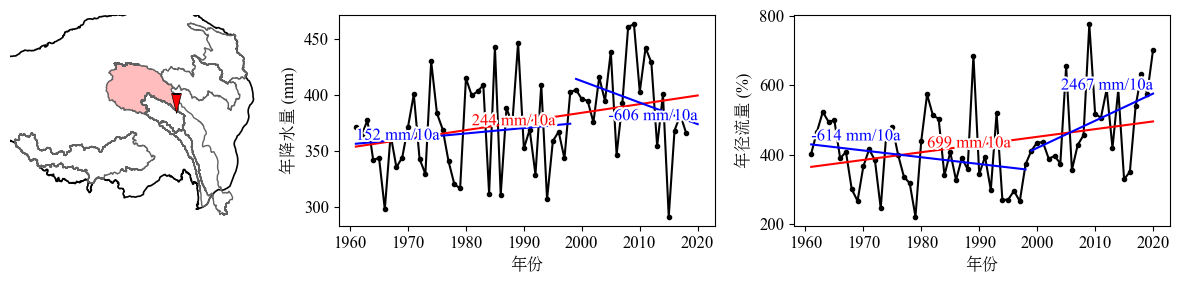

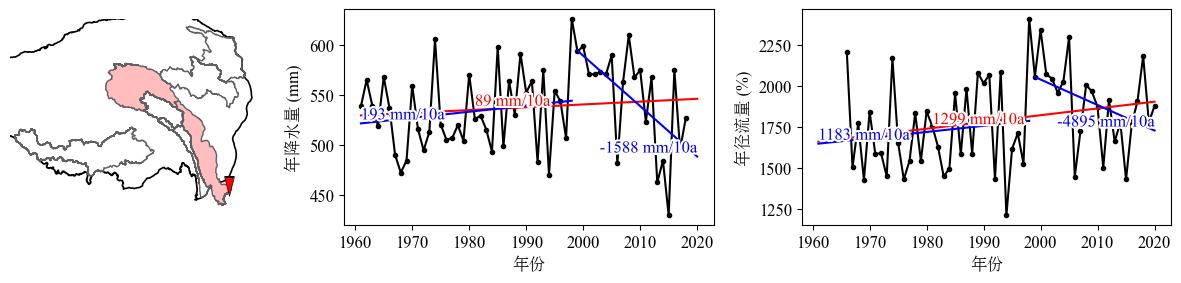

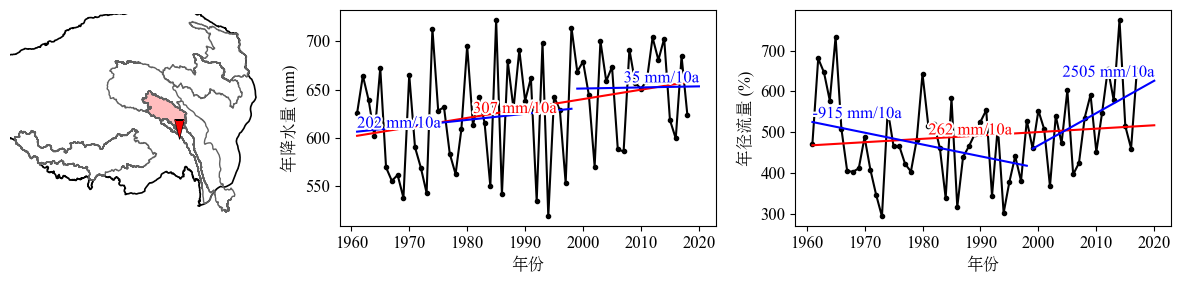

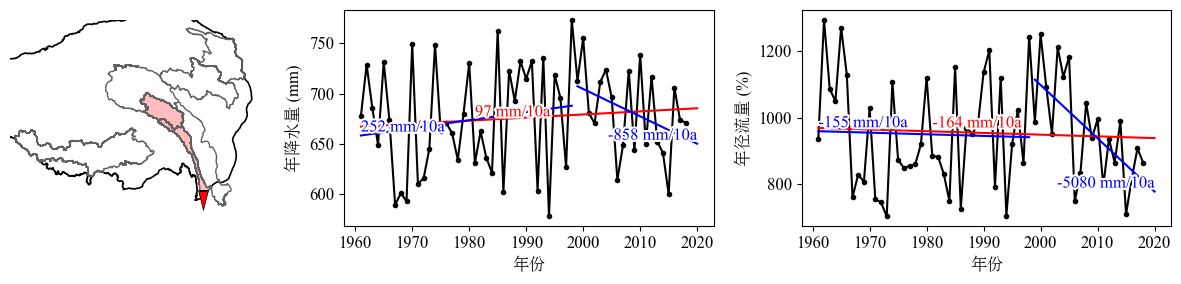

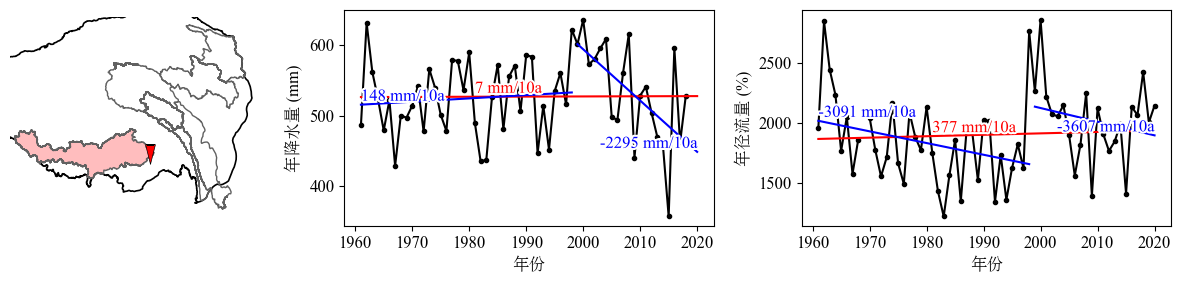

In [13]:
for b in range(len(basin_list)):
    basin = basin_list[b]
    hydro_show = hydro_show_list[b]
    fill = fill_list[b]

    fig = plt.figure(figsize=(12, 3))
    gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[2, 3, 3])

    ax1 = fig.add_subplot(gs[0, 0], projection=projection)
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    plot_assist_element(ax1, qtp_bound=True, study_cat=True, hydro_stations=True, hydro_stations_show=hydro_show, cat_fill=fill)

    all_hc = pd.read_csv(f"../data/hc/hc_{basin}.txt", sep='\t', parse_dates=['Time'], index_col='Time')
    all_hc = all_hc['1961-01-01':'2020-12-31']

    pre_series = all_hc['pre_cn05'].resample("YS").sum(min_count=3)
    # run_series = 100 * (all_hc['runoff'].resample("YS").mean() - all_hc['runoff'].resample("YS").mean().mean()) / all_hc['runoff'].resample("YS").mean().mean()
    run_series = all_hc['runoff'].resample("YS").mean()

    plot_trend_analysis(ax2, pre_series, '年降水量 (mm)', unit='mm')
    plot_trend_analysis(ax3, run_series, '年径流量 (%)', unit='mm')

    # ax2.plot(pre_series, color='black', marker='o', markersize=4)
    # ax3.plot(run_series, color='black', marker='o', markersize=4)

    plt.tight_layout()
    # plt.savefig(f"../figures/runoff_series/runoff_{basin}.pdf", bbox_inches='tight')